In [4]:
import numpy as np
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Flatten

def filter_set_by_base_quality(data, quality_threshold=0.05, drop_base_quality=True):
    features = data['features']
    labels = data['labels']

    list_above_threshold = []
    
    for i in range(features.shape[0]):
        if features[i, 4, 7] > quality_threshold:
            list_above_threshold.append(i)
    
    above_threshold_indices = np.array(list_above_threshold)
    
    above_threshold_features = features[above_threshold_indices]
    above_threshold_labels = labels[above_threshold_indices]
    
    if drop_base_quality:
        above_threshold_features = above_threshold_features[:, np.arange(above_threshold_features.shape[1]) != 4, :]
    
    return above_threshold_features, above_threshold_labels

def set_num_nucleotides(features, num = 7):
    if num > 7:
        print('Cannot have more than 7 nucleotides.')
    else:
        num_to_remove = 7 - num
        
        keep_from_start = num_to_remove
        keep_from_end = features.shape[2] - num_to_remove

        new_features = features[:, :, keep_from_start:keep_from_end]
        
        return new_features

def lstm_hybrid_run(trial): 

    num_nucleotides = trial.suggest_int("num_nucleotides", 1, 7)

    train_set = np.load('../data/ml_data/HG002_2_3_00_400k_train.npz')
    val_set = np.load('../data/ml_data/HG002_2_3_00_400k_val.npz')

    # build train set
    train_features, y_train = filter_set_by_base_quality(train_set)
    train_features = set_num_nucleotides(train_features, num_nucleotides)
    X_train = train_features.transpose((0, 2, 1))

    # build val set    
    val_features, y_val = filter_set_by_base_quality(val_set)
    val_features = set_num_nucleotides(val_features, num_nucleotides)
    X_val = val_features.transpose((0, 2, 1)) 

    # dynamically set input_shape for model
    full_window = num_nucleotides * 2 + 1
    input_shape = ((full_window), 5)   

    model = Sequential()

    # lstm layer
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))

    # convolutional layers & max pooling
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    # flatten
    model.add(Flatten())

    # dense/output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    epochs = 10

    for epoch in range(epochs):
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32)
        
        train_loss_history.append(history.history['loss'])
        train_accuracy_history.append(history.history['accuracy'])
        val_loss_history.append(history.history['val_loss'])
        val_accuracy_history.append(history.history['val_accuracy'])
        
        print(f"Epoch {epoch + 1}/{epochs} - "
            f"Train Loss: {history.history['loss'][0]:.4f}, "
            f"Train Acc: {history.history['accuracy'][0]:.4f}, "
            f"Val Loss: {history.history['val_loss'][0]:.4f}, "
            f"Val Acc: {history.history['val_accuracy'][0]:.4f}")
        
    accuracy = val_accuracy_history[len(val_accuracy_history) - 1]
    return accuracy

In [3]:
print(f"Training the LSTM-CNN hybrid model.")
study = optuna.create_study(direction="maximize")
study.optimize(lstm_hybrid_run, n_trials=10)
fig = optuna.visualization.plot_slice(study)
fig.show()

[I 2023-09-21 11:53:45,572] A new study created in memory with name: no-name-56fa272e-832d-45bc-bbce-95f8f6d52eba


Training the LSTM-CNN hybrid model.


[W 2023-09-21 11:53:49,374] Trial 0 failed with parameters: {'num_nucleotides': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\mmm\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\mmm\AppData\Local\Temp\ipykernel_18692\2064583559.py", line 88, in lstm_hybrid_run
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32)
  File "c:\Users\mmm\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\mmm\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
    tmp_logs = self.train_function(iterator)
  File "c:\Users\mmm\anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\mmm\anaconda3\lib\site-packages\tensorflow\python\e

In [45]:
"""
Hparams to optimize: 
num_hidden_layers = [1]
num_units = [32, 64, 128]
dropout_rates = [0.0, 0.1, 0.2]
activation_functions = ['relu', 'tanh']
learning_rates = [0.05, 0.1, 0.15]
momentum_values = [0.0, 0.1, 0.5, 0.9]
batch_sizes = [32, 64, 128]
"""

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
import optuna

def objective(trial):
    epochs = 10

    # hyperparameter tuning
    num_hidden = 1
    num_nucleotides = trial.suggest_int("num_nucleotides", 1, 7)
    num_unit = trial.suggest_int("num_unit", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.2)
    activation_function = trial.suggest_categorical("activation_function", ['relu', 'tanh'])
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.15)
    momentum = trial.suggest_float("momentum_values", 0.0, 0.9)
    batch_size = trial.suggest_int("batch_size", 32, 128)
    # num_hidden_layers = [1]
    # num_units = [32, 64, 128]
    # dropout_rates = [0.0, 0.1, 0.2]
    # activation_functions = ['relu', 'tanh']
    # learning_rates = [0.05, 0.1, 0.15]
    # momentum_values = [0.0, 0.1, 0.5, 0.9]
    # batch_sizes = [32, 64, 128]

    # build train set
    train_set = np.load('../data/ml_data/HG002_2_3_00_400k_train.npz')
    val_set = np.load('../data/ml_data/HG002_2_3_00_400k_val.npz')
    train_features, y_train = filter_set_by_base_quality(train_set)
    train_features = set_num_nucleotides(train_features, num_nucleotides)
    X_train = train_features.transpose((0, 2, 1))

    # build val set    
    val_features, y_val = filter_set_by_base_quality(val_set)
    val_features = set_num_nucleotides(val_features, num_nucleotides)
    X_val = val_features.transpose((0, 2, 1)) 

    # dynamically set input_shape for model
    full_window = num_nucleotides * 2 + 1
    input_shape = ((full_window), 5)  


    model = Sequential()
    for _ in range(num_hidden):
        if _ == 0:
            model.add(LSTM(num_unit, input_shape=input_shape, return_sequences=(num_hidden > 1)))
        else:
            model.add(LSTM(num_unit, return_sequences=(_ < num_hidden)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate, beta_1=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    for epoch in range(epochs):
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, verbose=0)
        val_accuracy = history.history['val_accuracy'][-1]

        print(
            f"Epoch {epoch + 1}/{epochs}, " 
            f"Val Acc: {val_accuracy:.4f}")
    
    return val_accuracy
        # if val_accuracy > best_accuracy:
        #         model_info = {
        #             'model': model,
        #             'val_accuracy': val_accuracy,
        #             'hyperparameters': {
        #                 'Hidden Layers': num_hidden,
        #                 'Units': num_unit,
        #                 'Dropout': dropout_rate,
        #                 'Activation': activation_function,
        #                 'Learning Rate': learning_rate,
        #                 'Momentum': momentum,
        #                 'Batch Size': batch_size
        #             }
        #         }
        #         top_models_info.append(model_info)
            


In [44]:
print(f"Training the LSTM-CNN hybrid model.")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2023-09-21 14:05:09,941] A new study created in memory with name: no-name-fb8cd14c-f52b-4265-9870-bd7e343bd4df


Training the LSTM-CNN hybrid model.
Epoch 1/10, Val Acc: 0.6243
Epoch 2/10, Val Acc: 0.6244
Epoch 3/10, Val Acc: 0.6219
Epoch 4/10, Val Acc: 0.6239
Epoch 5/10, Val Acc: 0.6245
Epoch 6/10, Val Acc: 0.6196
Epoch 7/10, Val Acc: 0.6258
Epoch 8/10, Val Acc: 0.6098
Epoch 9/10, Val Acc: 0.6248


[I 2023-09-21 14:07:12,285] Trial 0 finished with value: 0.6246668696403503 and parameters: {'num_nucleotides': 1, 'num_unit': 125, 'dropout_rate': 0.13926840282827055, 'activation_function': 'tanh', 'learning_rate': 0.060764667283037525, 'momentum_values': 0.4506896300222271, 'batch_size': 124}. Best is trial 0 with value: 0.6246668696403503.


Epoch 10/10, Val Acc: 0.6247
Epoch 1/10, Val Acc: 0.6801
Epoch 2/10, Val Acc: 0.6777
Epoch 3/10, Val Acc: 0.6792
Epoch 4/10, Val Acc: 0.6797
Epoch 5/10, Val Acc: 0.6806
Epoch 6/10, Val Acc: 0.6775
Epoch 7/10, Val Acc: 0.6362
Epoch 8/10, Val Acc: 0.6163
Epoch 9/10, Val Acc: 0.6727


[I 2023-09-21 14:11:10,811] Trial 1 finished with value: 0.6711483597755432 and parameters: {'num_nucleotides': 6, 'num_unit': 61, 'dropout_rate': 0.10683170710436969, 'activation_function': 'tanh', 'learning_rate': 0.06893458096257796, 'momentum_values': 0.4340930954576399, 'batch_size': 103}. Best is trial 1 with value: 0.6711483597755432.


Epoch 10/10, Val Acc: 0.6711
Epoch 1/10, Val Acc: 0.6241
Epoch 2/10, Val Acc: 0.6183
Epoch 3/10, Val Acc: 0.6239
Epoch 4/10, Val Acc: 0.6243
Epoch 5/10, Val Acc: 0.6244
Epoch 6/10, Val Acc: 0.6230
Epoch 7/10, Val Acc: 0.6144
Epoch 8/10, Val Acc: 0.5987
Epoch 9/10, Val Acc: 0.6136


[I 2023-09-21 14:13:27,633] Trial 2 finished with value: 0.5987371206283569 and parameters: {'num_nucleotides': 1, 'num_unit': 78, 'dropout_rate': 0.0508253183652321, 'activation_function': 'relu', 'learning_rate': 0.13111886431882505, 'momentum_values': 0.013029553331479959, 'batch_size': 73}. Best is trial 1 with value: 0.6711483597755432.


Epoch 10/10, Val Acc: 0.5987
Epoch 1/10, Val Acc: 0.6718
Epoch 2/10, Val Acc: 0.6642
Epoch 3/10, Val Acc: 0.6751
Epoch 4/10, Val Acc: 0.6647
Epoch 5/10, Val Acc: 0.6768
Epoch 6/10, Val Acc: 0.6771
Epoch 7/10, Val Acc: 0.6769
Epoch 8/10, Val Acc: 0.6742
Epoch 9/10, Val Acc: 0.6736


[I 2023-09-21 14:16:09,923] Trial 3 finished with value: 0.6759741902351379 and parameters: {'num_nucleotides': 6, 'num_unit': 38, 'dropout_rate': 0.03650978702960444, 'activation_function': 'tanh', 'learning_rate': 0.13454596065525962, 'momentum_values': 0.8303735631466352, 'batch_size': 125}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.6760
Epoch 1/10, Val Acc: 0.6335
Epoch 2/10, Val Acc: 0.6279
Epoch 3/10, Val Acc: 0.6178
Epoch 4/10, Val Acc: 0.6319
Epoch 5/10, Val Acc: 0.6354
Epoch 6/10, Val Acc: 0.6324
Epoch 7/10, Val Acc: 0.6331
Epoch 8/10, Val Acc: 0.6289
Epoch 9/10, Val Acc: 0.6310


[I 2023-09-21 14:19:25,013] Trial 4 finished with value: 0.6305250525474548 and parameters: {'num_nucleotides': 2, 'num_unit': 109, 'dropout_rate': 0.08764074634925723, 'activation_function': 'tanh', 'learning_rate': 0.11756902067039898, 'momentum_values': 0.2711492271872441, 'batch_size': 84}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.6305
Epoch 1/10, Val Acc: 0.6280
Epoch 2/10, Val Acc: 0.6340
Epoch 3/10, Val Acc: 0.5819
Epoch 4/10, Val Acc: 0.6336
Epoch 5/10, Val Acc: 0.6208
Epoch 6/10, Val Acc: 0.6343
Epoch 7/10, Val Acc: 0.6312
Epoch 8/10, Val Acc: 0.6322
Epoch 9/10, Val Acc: 0.6341


[I 2023-09-21 14:21:08,534] Trial 5 finished with value: 0.5931430459022522 and parameters: {'num_nucleotides': 2, 'num_unit': 53, 'dropout_rate': 0.10848979625994624, 'activation_function': 'tanh', 'learning_rate': 0.11011130648073042, 'momentum_values': 0.18666456127449063, 'batch_size': 116}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.5931
Epoch 1/10, Val Acc: 0.6772
Epoch 2/10, Val Acc: 0.6770
Epoch 3/10, Val Acc: 0.6740
Epoch 4/10, Val Acc: 0.6769
Epoch 5/10, Val Acc: 0.6762
Epoch 6/10, Val Acc: 0.5518
Epoch 7/10, Val Acc: 0.5537
Epoch 8/10, Val Acc: 0.5661
Epoch 9/10, Val Acc: 0.5972


[I 2023-09-21 14:23:41,712] Trial 6 finished with value: 0.5722551941871643 and parameters: {'num_nucleotides': 6, 'num_unit': 40, 'dropout_rate': 0.14428201848410713, 'activation_function': 'relu', 'learning_rate': 0.1411862583561156, 'momentum_values': 0.8774214236065269, 'batch_size': 112}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.5723
Epoch 1/10, Val Acc: 0.6193
Epoch 2/10, Val Acc: 0.6249
Epoch 3/10, Val Acc: 0.6233
Epoch 4/10, Val Acc: 0.6248
Epoch 5/10, Val Acc: 0.6247
Epoch 6/10, Val Acc: 0.6236
Epoch 7/10, Val Acc: 0.6232
Epoch 8/10, Val Acc: 0.6180
Epoch 9/10, Val Acc: 0.6200


[I 2023-09-21 14:27:42,611] Trial 7 finished with value: 0.6167439222335815 and parameters: {'num_nucleotides': 1, 'num_unit': 92, 'dropout_rate': 0.16200787342299727, 'activation_function': 'relu', 'learning_rate': 0.12919703833200852, 'momentum_values': 0.10428004833181026, 'batch_size': 49}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.6167
Epoch 1/10, Val Acc: 0.6829
Epoch 2/10, Val Acc: 0.6820
Epoch 3/10, Val Acc: 0.6838
Epoch 4/10, Val Acc: 0.6826
Epoch 5/10, Val Acc: 0.6838
Epoch 6/10, Val Acc: 0.6868
Epoch 7/10, Val Acc: 0.6840
Epoch 8/10, Val Acc: 0.5553
Epoch 9/10, Val Acc: 0.5527


[I 2023-09-21 14:31:03,782] Trial 8 finished with value: 0.5514633655548096 and parameters: {'num_nucleotides': 7, 'num_unit': 38, 'dropout_rate': 0.01421060538319845, 'activation_function': 'tanh', 'learning_rate': 0.08412860720173883, 'momentum_values': 0.2368770965969641, 'batch_size': 105}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.5515
Epoch 1/10, Val Acc: 0.6322
Epoch 2/10, Val Acc: 0.6290
Epoch 3/10, Val Acc: 0.6352
Epoch 4/10, Val Acc: 0.6302
Epoch 5/10, Val Acc: 0.6310
Epoch 6/10, Val Acc: 0.6300
Epoch 7/10, Val Acc: 0.6297
Epoch 8/10, Val Acc: 0.6320
Epoch 9/10, Val Acc: 0.6341


[I 2023-09-21 14:36:50,863] Trial 9 finished with value: 0.6210175156593323 and parameters: {'num_nucleotides': 2, 'num_unit': 89, 'dropout_rate': 0.0668790485641814, 'activation_function': 'relu', 'learning_rate': 0.11916042513627807, 'momentum_values': 0.5642643264211783, 'batch_size': 35}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.6210
Epoch 1/10, Val Acc: 0.6559
Epoch 2/10, Val Acc: 0.6586
Epoch 3/10, Val Acc: 0.6601
Epoch 4/10, Val Acc: 0.6563
Epoch 5/10, Val Acc: 0.6560
Epoch 6/10, Val Acc: 0.6581
Epoch 7/10, Val Acc: 0.6601
Epoch 8/10, Val Acc: 0.6528
Epoch 9/10, Val Acc: 0.6554


[I 2023-09-21 14:40:34,133] Trial 10 finished with value: 0.6490360498428345 and parameters: {'num_nucleotides': 4, 'num_unit': 65, 'dropout_rate': 0.005177096415271483, 'activation_function': 'tanh', 'learning_rate': 0.14336114292097693, 'momentum_values': 0.853982851207013, 'batch_size': 84}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.6490
Epoch 1/10, Val Acc: 0.6702
Epoch 2/10, Val Acc: 0.6697
Epoch 3/10, Val Acc: 0.6678
Epoch 4/10, Val Acc: 0.5024
Epoch 5/10, Val Acc: 0.5383
Epoch 6/10, Val Acc: 0.5427
Epoch 7/10, Val Acc: 0.5409
Epoch 8/10, Val Acc: 0.5432
Epoch 9/10, Val Acc: 0.5373


[I 2023-09-21 14:43:58,640] Trial 11 finished with value: 0.5408033132553101 and parameters: {'num_nucleotides': 5, 'num_unit': 57, 'dropout_rate': 0.18749954057714113, 'activation_function': 'tanh', 'learning_rate': 0.09299649912097235, 'momentum_values': 0.6232967445269788, 'batch_size': 98}. Best is trial 3 with value: 0.6759741902351379.


Epoch 10/10, Val Acc: 0.5408
Epoch 1/10, Val Acc: 0.6804
Epoch 2/10, Val Acc: 0.6888
Epoch 3/10, Val Acc: 0.6721
Epoch 4/10, Val Acc: 0.6675
Epoch 5/10, Val Acc: 0.6822
Epoch 6/10, Val Acc: 0.6838
Epoch 7/10, Val Acc: 0.6843
Epoch 8/10, Val Acc: 0.6835
Epoch 9/10, Val Acc: 0.6836


[I 2023-09-21 14:46:30,823] Trial 12 finished with value: 0.6850736141204834 and parameters: {'num_nucleotides': 7, 'num_unit': 32, 'dropout_rate': 0.04080484117313032, 'activation_function': 'tanh', 'learning_rate': 0.052611892922300174, 'momentum_values': 0.7048778750957496, 'batch_size': 122}. Best is trial 12 with value: 0.6850736141204834.


Epoch 10/10, Val Acc: 0.6851
Epoch 1/10, Val Acc: 0.6849
Epoch 2/10, Val Acc: 0.6853
Epoch 3/10, Val Acc: 0.6834
Epoch 4/10, Val Acc: 0.6852
Epoch 5/10, Val Acc: 0.6879
Epoch 6/10, Val Acc: 0.6833
Epoch 7/10, Val Acc: 0.6873
Epoch 8/10, Val Acc: 0.6855
Epoch 9/10, Val Acc: 0.6775


[I 2023-09-21 14:49:00,558] Trial 13 finished with value: 0.6882427930831909 and parameters: {'num_nucleotides': 7, 'num_unit': 33, 'dropout_rate': 0.02960539741902061, 'activation_function': 'tanh', 'learning_rate': 0.05418340717724673, 'momentum_values': 0.7296436643090708, 'batch_size': 128}. Best is trial 13 with value: 0.6882427930831909.


Epoch 10/10, Val Acc: 0.6882
Epoch 1/10, Val Acc: 0.6827
Epoch 2/10, Val Acc: 0.6785
Epoch 3/10, Val Acc: 0.6885
Epoch 4/10, Val Acc: 0.6788
Epoch 5/10, Val Acc: 0.6875
Epoch 6/10, Val Acc: 0.6773
Epoch 7/10, Val Acc: 0.6844
Epoch 8/10, Val Acc: 0.6877
Epoch 9/10, Val Acc: 0.6835


[I 2023-09-21 14:51:22,685] Trial 14 finished with value: 0.6890350580215454 and parameters: {'num_nucleotides': 7, 'num_unit': 32, 'dropout_rate': 0.03220398430553935, 'activation_function': 'tanh', 'learning_rate': 0.05018008680064961, 'momentum_values': 0.715686791242588, 'batch_size': 126}. Best is trial 14 with value: 0.6890350580215454.


Epoch 10/10, Val Acc: 0.6890
Epoch 1/10, Val Acc: 0.6525
Epoch 2/10, Val Acc: 0.6597
Epoch 3/10, Val Acc: 0.6573
Epoch 4/10, Val Acc: 0.6599
Epoch 5/10, Val Acc: 0.6610
Epoch 6/10, Val Acc: 0.6595
Epoch 7/10, Val Acc: 0.6614
Epoch 8/10, Val Acc: 0.6586
Epoch 9/10, Val Acc: 0.6504


[I 2023-09-21 14:54:41,107] Trial 15 finished with value: 0.6593359112739563 and parameters: {'num_nucleotides': 4, 'num_unit': 48, 'dropout_rate': 0.019419640868527953, 'activation_function': 'tanh', 'learning_rate': 0.05057934895932517, 'momentum_values': 0.745393278332431, 'batch_size': 68}. Best is trial 14 with value: 0.6890350580215454.


Epoch 10/10, Val Acc: 0.6593
Epoch 1/10, Val Acc: 0.6572
Epoch 2/10, Val Acc: 0.6616
Epoch 3/10, Val Acc: 0.6618
Epoch 4/10, Val Acc: 0.6699
Epoch 5/10, Val Acc: 0.6610
Epoch 6/10, Val Acc: 0.6691
Epoch 7/10, Val Acc: 0.6700
Epoch 8/10, Val Acc: 0.6678
Epoch 9/10, Val Acc: 0.6670


[I 2023-09-21 14:58:12,351] Trial 16 finished with value: 0.665530264377594 and parameters: {'num_nucleotides': 5, 'num_unit': 68, 'dropout_rate': 0.07055604933093501, 'activation_function': 'tanh', 'learning_rate': 0.07086682622513635, 'momentum_values': 0.7316519968881877, 'batch_size': 94}. Best is trial 14 with value: 0.6890350580215454.


Epoch 10/10, Val Acc: 0.6655
Epoch 1/10, Val Acc: 0.6824
Epoch 2/10, Val Acc: 0.6856
Epoch 3/10, Val Acc: 0.6821
Epoch 4/10, Val Acc: 0.6875
Epoch 5/10, Val Acc: 0.6761
Epoch 6/10, Val Acc: 0.6863
Epoch 7/10, Val Acc: 0.6858
Epoch 8/10, Val Acc: 0.5084
Epoch 9/10, Val Acc: 0.5709


[I 2023-09-21 15:01:19,194] Trial 17 finished with value: 0.5916304588317871 and parameters: {'num_nucleotides': 7, 'num_unit': 44, 'dropout_rate': 0.0023670777768882607, 'activation_function': 'tanh', 'learning_rate': 0.07386471248105676, 'momentum_values': 0.584516716692829, 'batch_size': 114}. Best is trial 14 with value: 0.6890350580215454.


Epoch 10/10, Val Acc: 0.5916
Epoch 1/10, Val Acc: 0.6667
Epoch 2/10, Val Acc: 0.6661
Epoch 3/10, Val Acc: 0.6681
Epoch 4/10, Val Acc: 0.6698
Epoch 5/10, Val Acc: 0.6684
Epoch 6/10, Val Acc: 0.6687
Epoch 7/10, Val Acc: 0.6670
Epoch 8/10, Val Acc: 0.6703
Epoch 9/10, Val Acc: 0.6661


[I 2023-09-21 15:04:58,932] Trial 18 finished with value: 0.6700439453125 and parameters: {'num_nucleotides': 5, 'num_unit': 73, 'dropout_rate': 0.028429137792370517, 'activation_function': 'relu', 'learning_rate': 0.059452822597425264, 'momentum_values': 0.7547077388922412, 'batch_size': 128}. Best is trial 14 with value: 0.6890350580215454.


Epoch 10/10, Val Acc: 0.6700
Epoch 1/10, Val Acc: 0.6463
Epoch 2/10, Val Acc: 0.6393
Epoch 3/10, Val Acc: 0.6464
Epoch 4/10, Val Acc: 0.6386
Epoch 5/10, Val Acc: 0.6469
Epoch 6/10, Val Acc: 0.6471
Epoch 7/10, Val Acc: 0.5596
Epoch 8/10, Val Acc: 0.5750
Epoch 9/10, Val Acc: 0.5876


[I 2023-09-21 15:09:56,403] Trial 19 finished with value: 0.584283709526062 and parameters: {'num_nucleotides': 3, 'num_unit': 90, 'dropout_rate': 0.05911800683471978, 'activation_function': 'tanh', 'learning_rate': 0.0824760979483588, 'momentum_values': 0.6409048374528657, 'batch_size': 54}. Best is trial 14 with value: 0.6890350580215454.


Epoch 10/10, Val Acc: 0.5843


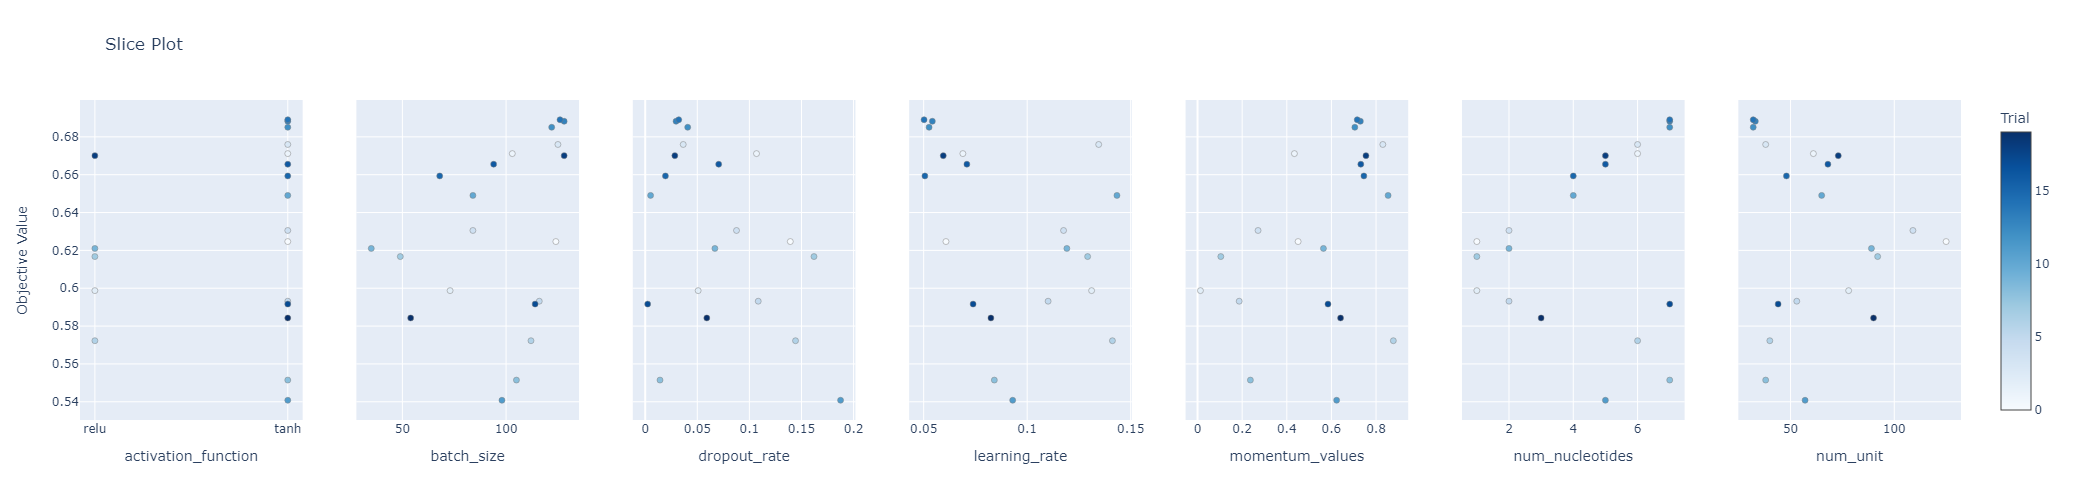

In [46]:
from IPython.display import Image

fig1 = optuna.visualization.plot_slice(study)
Image(fig1.to_image(format="png"))

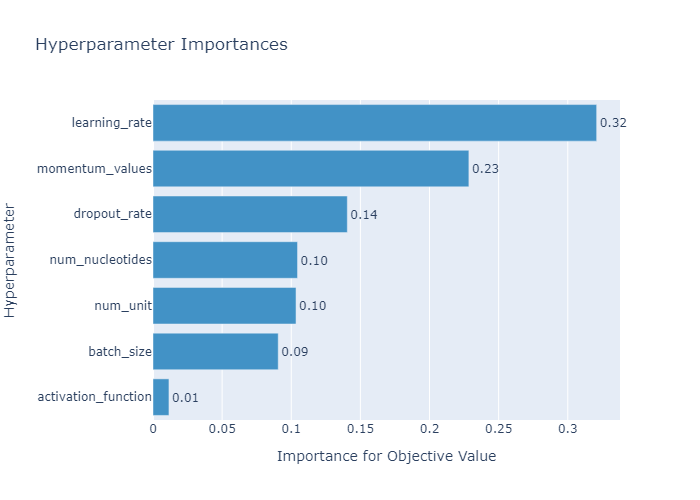

In [47]:
fig2 = optuna.visualization.plot_param_importances(study)
Image(fig2.to_image(format="png"))

In [48]:
print('Best trial:')
print(f"accuracy: {study.best_trial.value}")
study.best_trial.params


Best trial:
accuracy: 0.6890350580215454


{'num_nucleotides': 7,
 'num_unit': 32,
 'dropout_rate': 0.03220398430553935,
 'activation_function': 'tanh',
 'learning_rate': 0.05018008680064961,
 'momentum_values': 0.715686791242588,
 'batch_size': 126}